In [3]:
import pandas as pd
import numpy as np

# Visualizaation
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from collections import Counter

# Handling Imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold,train_test_split, cross_val_score

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
import warnings

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Preprocessing

In [4]:
# import dataset 
df = pd.read_excel('dataset/Cleaned_E_Commerce_Dataset.xlsx', sheet_name='Sheet1')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5051 entries, 0 to 5050
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5051 non-null   int64  
 1   Tenure                       5051 non-null   int64  
 2   PreferredLoginDevice         5051 non-null   object 
 3   CityTier                     5051 non-null   int64  
 4   WarehouseToHome              5051 non-null   int64  
 5   PreferredPaymentMode         5051 non-null   object 
 6   Gender                       5051 non-null   object 
 7   HourSpendOnApp               5051 non-null   int64  
 8   NumberOfDeviceRegistered     5051 non-null   int64  
 9   PreferedOrderCat             5051 non-null   object 
 10  SatisfactionScore            5051 non-null   int64  
 11  MaritalStatus                5051 non-null   object 
 12  NumberOfAddress              5051 non-null   int64  
 13  Complain          

### Define X & y

In [6]:
X = df.drop(columns='Churn')
y = df['Churn']

In [7]:
vif_transformer = ColumnTransformer([
  ('Robust', RobustScaler(), ['CashbackAmount','DaySinceLastOrder','OrderCount','CouponUsed']),
  ('Minmax', MinMaxScaler(),['Tenure','WarehouseToHome','HourSpendOnApp','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','OrderAmountHikeFromlastYear']),
  ('Onehot', OneHotEncoder(drop='first'), ['PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus','CityTier']),
], remainder='passthrough')

vif_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('Robust', RobustScaler(),
                                 ['CashbackAmount', 'DaySinceLastOrder',
                                  'OrderCount', 'CouponUsed']),
                                ('Minmax', MinMaxScaler(),
                                 ['Tenure', 'WarehouseToHome', 'HourSpendOnApp',
                                  'NumberOfDeviceRegistered',
                                  'SatisfactionScore', 'NumberOfAddress',
                                  'OrderAmountHikeFromlastYear']),
                                ('Onehot', OneHotEncoder(drop='first'),
                                 ['PreferredLoginDevice',
                                  'PreferredPaymentMode', 'Gender',
                                  'PreferedOrderCat', 'MaritalStatus',
                                  'CityTier'])])

### Check Multicolinearity

In [8]:
def calc_vif(X):
  vif = pd.DataFrame()
  vif["Feature"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  return vif.sort_values(by='VIF', ascending=False)

In [9]:
# Fit and transform the data
X_transformed = vif_transformer.fit_transform(X)

# Extract feature names
robust_features = vif_transformer.named_transformers_['Robust'].get_feature_names_out().tolist()
minmax_features = vif_transformer.named_transformers_['Minmax'].get_feature_names_out().tolist()
onehot_features = vif_transformer.named_transformers_['Onehot'].get_feature_names_out().tolist()

# Get the names of the remaining columns that were passed through
remaining_features = ['Complain']

# Combine all feature names
all_feature_names = robust_features + minmax_features + onehot_features + remaining_features

# Create a DataFrame with the transformed data
X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

# Calculate VIF for the transformed DataFrame
vif_data = calc_vif(X_transformed_df)
vif_data.head()

,Feature,VIF
6,HourSpendOnApp,21.963885
0,CashbackAmount,11.314814
19,PreferedOrderCat_Mobile Phone,11.279017
7,NumberOfDeviceRegistered,8.950883
18,PreferedOrderCat_Laptop & Accessory,5.854164


In [10]:
X_transformed_df.drop(columns='HourSpendOnApp', inplace=True)
calc_vif(X_transformed_df).head()

,Feature,VIF
0,CashbackAmount,9.350763
18,PreferedOrderCat_Mobile Phone,8.476975
6,NumberOfDeviceRegistered,8.378712
17,PreferedOrderCat_Laptop & Accessory,4.928339
12,PreferredPaymentMode_Debit Card,4.557918


In [11]:
X = X.drop(columns=['HourSpendOnApp'])

**Insight:**
  * In this study case, we apply a threshold for the vif score of 10 points to keep valuable information from being lost.
  * The result based on VIF methode, there feature that have high VIF score `HourSpendOnApp` with score above 10.
  * We try to drop one by one features with high VIF score started with `HourSpendOnApp` column, and the result are several columns experienced a decrease in viv score with highest score is `CashbackAmount`.
  * Furthermore, there aren't features above 10 we consider to  retain these features as final dataset for modelling process.

### Data Splitting

In [48]:
# Divide train and test data with 80% for training and 25% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)
Counter(y)

Shape of training data: (3788, 17)
Shape of testing data: (1263, 17)


Counter({0: 4213, 1: 838})

In [13]:
display(X_train, X_test, y_train, y_test)

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
1258,0,Mobile Phone,1,13,Cash on Delivery,Male,4,Mobile Phone,1,Married,6,0,12,0,1,3,123.67
3740,10,Computer,2,9,UPI,Male,5,Laptop & Accessory,1,Single,3,0,22,2,2,9,163.86
4307,6,Mobile Phone,1,16,Debit Card,Female,4,Laptop & Accessory,1,Married,3,1,13,2,2,6,188.22
1116,9,Computer,2,14,UPI,Female,4,Mobile Phone,1,Married,7,0,11,1,1,2,121.80
1918,0,Mobile Phone,1,31,Debit Card,Male,3,Mobile Phone,1,Single,2,1,24,0,1,1,127.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,6,Computer,1,7,Debit Card,Male,4,Mobile Phone,1,Married,2,0,13,2,2,3,148.14
466,9,Mobile Phone,1,6,UPI,Female,3,Laptop & Accessory,4,Divorced,1,0,15,0,1,5,152.28
3092,1,Mobile Phone,3,7,Debit Card,Male,5,Fashion,3,Divorced,7,0,12,2,12,3,231.09
3772,1,Computer,2,29,UPI,Female,5,Mobile Phone,4,Married,3,0,13,2,2,1,153.63


,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
4711,14,Mobile Phone,1,8,Debit Card,Male,4,Mobile Phone,4,Married,5,0,23,2,2,4,148.87
691,1,Mobile Phone,1,8,Debit Card,Male,4,Mobile Phone,4,Divorced,1,0,17,0,1,4,132.01
65,25,Mobile Phone,1,6,Debit Card,Male,4,Others,3,Divorced,1,0,15,1,11,9,299.99
3426,5,Mobile Phone,3,15,Debit Card,Male,4,Fashion,2,Married,3,0,19,3,2,10,232.93
4683,2,Mobile Phone,1,8,Cash on Delivery,Male,4,Mobile Phone,5,Single,4,0,12,2,2,3,145.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,28,Mobile Phone,2,26,Credit Card,Male,4,Fashion,4,Divorced,4,0,16,4,2,2,232.25
332,14,Computer,1,8,UPI,Female,4,Laptop & Accessory,3,Single,3,1,17,0,1,7,168.11
1340,5,Computer,1,8,Debit Card,Male,3,Mobile Phone,1,Single,1,0,13,1,3,6,130.68
3062,21,Mobile Phone,3,9,Debit Card,Female,5,Mobile Phone,2,Single,3,1,19,2,2,3,157.94


1258    1
3740    0
4307    0
1116    1
1918    1
       ..
4426    0
466     0
3092    1
3772    1
860     0
Name: Churn, Length: 3788, dtype: int64

4711    0
691     0
65      0
3426    0
4683    0
       ..
2907    0
332     0
1340    0
3062    0
2929    0
Name: Churn, Length: 1263, dtype: int64

In [14]:
transformer = ColumnTransformer([
  ('Robust', RobustScaler(), ['CashbackAmount','DaySinceLastOrder','OrderCount','CouponUsed']),
  ('Minmax', MinMaxScaler(),['Tenure','WarehouseToHome','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','OrderAmountHikeFromlastYear']),
  ('Onehot', OneHotEncoder(drop='first'), ['PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus','CityTier']),
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('Robust', RobustScaler(),
                                 ['CashbackAmount', 'DaySinceLastOrder',
                                  'OrderCount', 'CouponUsed']),
                                ('Minmax', MinMaxScaler(),
                                 ['Tenure', 'WarehouseToHome',
                                  'NumberOfDeviceRegistered',
                                  'SatisfactionScore', 'NumberOfAddress',
                                  'OrderAmountHikeFromlastYear']),
                                ('Onehot', OneHotEncoder(drop='first'),
                                 ['PreferredLoginDevice',
                                  'PreferredPaymentMode', 'Gender',
                                  'PreferedOrderCat', 'MaritalStatus',
                                  'CityTier'])])

**Insight:**
  * We have slightly imbalanced dataset with 0: 4224, 1: 838 of labels distribution, we consider to apply **oversampling** methode later on.
  * In ColumnTransformer, we choose several type encoders and scaler:
    * **RobustScaler**  : For features that have so many outliers such as `CashbackAmount`,`DaySinceLastOrder`,`OrderCount`,`CouponUsed`.
    * **MinMaxScaler**  : For features with varying ranges such as `Tenure, WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear`.
    * **OneHotEncoder** : To encode features with multiple category values to numeric such as `PreferredLoginDevice`,`PreferredPaymentMode`,`Gender`,`PreferedOrderCat`,`MaritalStatus`, `CityTier`.

---
# **Modeling**
---

### Model Benchmarking

In [15]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()
Adaboost = AdaBoostClassifier()

models = [logreg,knn,dt,rf,xgb,lgbm,Adaboost]

score=[]
avrg=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=10)
    estimator=Pipeline([
        ('preprocess', transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='f1')
    score.append(model_cv)
    avrg.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Adaboost'],'mean f1 sore':avrg,'sdev':std}).set_index('model').sort_values(by='mean f1 sore',ascending=False)

[LightGBM] [Info] Number of positive: 570, number of negative: 2839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 3409, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167204 -> initscore=-1.605571
[LightGBM] [Info] Start training from score -1.605571
[LightGBM] [Info] Number of positive: 570, number of negative: 2839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 3409, number of used features: 25
[LightGBM] [Info] [binary:Bo

,mean f1 sore,sdev
model,,
XGBoost,0.866259,0.026276
LightGBM,0.854038,0.032384
Random Forest,0.839159,0.041741
Decision Tree,0.788355,0.028054
Adaboost,0.630721,0.047752
Logistic Regression,0.598599,0.055589
KNN,0.521826,0.049371


**Insight:**
  * Based on the comparison of roc_auc score models, we can see that `XGBoost` and `LightGBM` are the 2 best models. Therefore, we benchmark these models with the test set and compare them to find the best model.

In [16]:
models = [xgb,lgbm]
target_names = ['Churn', 'Stay']
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1 = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess', transformer),
        ('model',i)])
    X_train,X_test
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)



for i,j in zip(models, ['XGBoost','LightGBM','Decision Tree']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    y_pred_binary = (y_predict_proba >= 0.5).astype(int)
    f1.append(recall_score(y_test,y_pred_binary))
    print(j,'\n', classification_report(y_test,y_pred_binary))
    
pd.DataFrame({'model':['XGBoost','LightGBM'],
             'f1 score':f1}).set_index('model').sort_values(by='f1 score',ascending=False)

XGBoost 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1059
           1       0.90      0.86      0.88       204

    accuracy                           0.96      1263
   macro avg       0.94      0.92      0.93      1263
weighted avg       0.96      0.96      0.96      1263

[LightGBM] [Info] Number of positive: 634, number of negative: 3154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 3788, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167371 -> initscore=-1.604378
[LightGBM] [Info] Start training from score -1.604378
LightGBM 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97 

,f1 score
model,
XGBoost,0.857843
LightGBM,0.799020


**Insight:**
  * Based on the scores of these models, `XGBoost` is the best model. So we choose `xgb` as the final model we use.

In [ ]:
model = {'XGBoost' : xgb}
target_names = ['Stay', 'Churn']
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def evaluate_model(model, X_test, y_test):
    '''Model evaluation function'''
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return roc_auc, accuracy, precision, recall, f1

def y_pred_func(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluation train dan test data
    train_metrics = evaluate_model(model, X_train, y_train)
    test_metrics = evaluate_model(model, X_test, y_test)
    
    return train_metrics, test_metrics


def confusionmatrix_report(models, X_train, y_train, X_test, y_test, target_names):
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        used_model = model.predict(X_test)

        print()
        print('\t', model_name)
        print('\t', '=' * (len(model_name) + 30))

        # Display confusion matrix for y_test and predictions
        conf_matrix = confusion_matrix(y_test, used_model)
        conf_df = pd.DataFrame(conf_matrix, columns=target_names, index=target_names)
        conf_df.index.name = 'True Labels'
        conf_df = conf_df.rename_axis('Predicted Labels', axis='columns')
        display(conf_df)

        # Display classification report
        print()
        print(classification_report(y_test, used_model, target_names=target_names))



In [18]:
def check_overfitting(model):
    # Calculate metrics on training set using cross-validation
    train_accuracy_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy').mean()
    train_recall_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall').mean()
    train_precision_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='precision').mean()
    train_f1_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1').mean()

    # Fit the model on the whole training set before evaluating on the test set
    model.fit(X_train, y_train)

    # Calculate metrics on test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Create a DataFrame for comparison
    metrics_df = pd.DataFrame({
        'Metric': ['Accucary', 'Recall', 'Precision', 'F1-Score'],
        'Train_CV': [train_accuracy_cv, train_recall_cv, train_precision_cv, train_f1_cv],
        'Test': [test_accuracy, test_recall, test_precision, test_f1]
    })

    # Calculate percentage difference
    metrics_df['Difference (%)'] = ((metrics_df['Train_CV'] - metrics_df['Test']) / metrics_df['Train_CV']) * 100
    metrics_df = metrics_df.round(3)

    # Display the DataFrame
    display(metrics_df)

    # Check for overfitting (10% difference threshold)
    overfitting = any(abs(metrics_df['Difference (%)']) >= 10 )

    if overfitting:
        print("\nModel might be overfitting. Consider regularization or other techniques.")
    else:
        print("\nModel does not show signs of significant overfitting based on the 10% threshold.")

### Comparing model w and w/o oversampling

In [49]:
first_pipeline = Pipeline([
    ('preprocess', transformer),
    ('model',xgb)])
estimator.fit(X_train, y_train)

ROS_pipeline = ImbPipeline([
    ('preprocess',transformer),
    ('ros', RandomOverSampler(random_state=42)),
    ('model', xgb)
])

SMOTE_pipeline = ImbPipeline([
    ('preprocess',transformer),
    ('smote', SMOTE(random_state=42)),
    ('model', xgb)
])

# Evaluation w/o oversampling
train_metrics_first_pipeline, test_metrics_first_pipeline = y_pred_func(first_pipeline, X_train, y_train, X_test, y_test)

# Evaluation w ROS
train_metrics_ROS_pipeline, test_metrics_ROS_pipeline = y_pred_func(ROS_pipeline, X_train, y_train, X_test, y_test)

# Evaluation w SMOTE
train_metrics_SMOTE_pipeline, test_metrics_SMOTE_pipeline = y_pred_func(SMOTE_pipeline, X_train, y_train, X_test, y_test)


results = pd.DataFrame({
  'Metric': ['Roc_auc', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
  'Without oversampling - Train': train_metrics_first_pipeline,
  'Without oversampling - Test': test_metrics_first_pipeline,
  'With ROS - Train': train_metrics_ROS_pipeline,
  'With ROS - Test': test_metrics_ROS_pipeline,
  'With SMOTE - Train' : train_metrics_SMOTE_pipeline,
  'With SMOTE - Test' : test_metrics_SMOTE_pipeline
})

results

,Metric,Without oversampling - Train,Without oversampling - Test,With ROS - Train,With ROS - Test,With SMOTE - Train,With SMOTE - Test
0,Roc_auc,1.0,0.919479,1.0,0.923999,1.0,0.913542
1,Accuracy,1.0,0.961203,1.0,0.958828,1.0,0.961203
2,Precision,1.0,0.897436,1.0,0.872549,1.0,0.910053
3,Recall,1.0,0.857843,1.0,0.872549,1.0,0.843137
4,F1 Score,1.0,0.877193,1.0,0.872549,1.0,0.875318


In [20]:

compare_oversample = {
  'ROS' : ROS_pipeline,
  'SMOTE' : SMOTE_pipeline,
  'Without oversampling' : first_pipeline
  }

confusionmatrix_report(compare_oversample,X_train, y_train, X_test, y_test, target_names)


	 ROS


Predicted Labels,Stay,Churn
True Labels,,
Stay,1033,26
Churn,26,178



              precision    recall  f1-score   support

        Stay       0.98      0.98      0.98      1059
       Churn       0.87      0.87      0.87       204

    accuracy                           0.96      1263
   macro avg       0.92      0.92      0.92      1263
weighted avg       0.96      0.96      0.96      1263


	 SMOTE


Predicted Labels,Stay,Churn
True Labels,,
Stay,1042,17
Churn,32,172



              precision    recall  f1-score   support

        Stay       0.97      0.98      0.98      1059
       Churn       0.91      0.84      0.88       204

    accuracy                           0.96      1263
   macro avg       0.94      0.91      0.93      1263
weighted avg       0.96      0.96      0.96      1263


	 Without oversampling


Predicted Labels,Stay,Churn
True Labels,,
Stay,1039,20
Churn,29,175



              precision    recall  f1-score   support

        Stay       0.97      0.98      0.98      1059
       Churn       0.90      0.86      0.88       204

    accuracy                           0.96      1263
   macro avg       0.94      0.92      0.93      1263
weighted avg       0.96      0.96      0.96      1263



Based on these result, we choose without oversampling estimator since it has highest score based on f1 result. And f1 score is appropriate metric for handling imbalance data.

In [21]:
before_tuning = evaluate_model(estimator,X_test,y_test)

before_tuning_score = pd.DataFrame({
  'Metric': ['Roc_auc', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
  'Before Tuning': before_tuning,
})

before_tuning_score

,Metric,Before Tuning
0,Roc_auc,0.890539
1,Accuracy,0.952494
2,Precision,0.895604
3,Recall,0.799020
4,F1 Score,0.844560


### Hyperparameter Tuning

In [22]:
estimator = ImbPipeline([
        ('preprocess',transformer),
        ('model', xgb)
    ])

# Hyper parameter 
hyperparam_space = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [3, 5, 7, 9, 11],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.4, 0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 1, 2, 4, 6],
    'model__reg_lambda': [0, 1, 2, 4, 6],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__min_child_weight': [1, 2, 3, 4]
}

# Use random sampler as cross validation
random_xgb = RandomizedSearchCV(
    estimator, 
    param_distributions = hyperparam_space,
    n_iter = 100 ,
    cv = kf, 
    scoring = 'f1', 
    n_jobs = -1,
    random_state = 1  
)

In [23]:
# Train tuned model
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('Robust',
                                                                               RobustScaler(),
                                                                               ['CashbackAmount',
                                                                                'DaySinceLastOrder',
                                                                                'OrderCount',
                                                                                'CouponUsed']),
                                                                              ('Minmax',
                                                                               MinMaxScaler(),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'NumberOfDeviceRegistered',
                                                                                'Sa...
                   param_distributions={'model__colsample_bytree': [0.4, 0.6,
                                                                    0.8, 1.0],
                                        'model__gamma': [0, 0.1, 0.2, 0.3],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2],
                                        'model__max_depth': [3, 5, 7, 9, 11],
                                        'model__min_child_weight': [1, 2, 3, 4],
                                        'model__n_estimators': [100, 200, 300,
                                                                400, 500],
                                        'model__reg_alpha': [0, 1, 2, 4, 6],
                                        'model__reg_lambda': [0, 1, 2, 4, 6],
                                        'model__subsample': [0.4, 0.6, 0.8,
                                                             1.0]},
                   random_state=1, scoring='f1')

In [24]:
pd.DataFrame(random_xgb.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_lambda,param_model__reg_alpha,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
26,0.371997,0.009361,0.023241,0.003970,1.0,0,0,200,1,9,...,0.959350,0.903226,0.900000,0.834783,0.854701,0.806723,0.873950,0.876998,0.039121,1
20,0.772512,0.019162,0.028390,0.004246,0.6,6,0,400,1,11,...,0.918033,0.904762,0.900000,0.840336,0.840336,0.803279,0.854701,0.865614,0.033180,2
48,0.440143,0.008579,0.024526,0.003628,0.8,4,0,200,1,11,...,0.934426,0.859504,0.871795,0.817391,0.837607,0.816667,0.834783,0.856993,0.032659,3
23,0.337860,0.023944,0.026201,0.011082,1.0,0,0,200,1,7,...,0.907563,0.840336,0.881356,0.803419,0.796610,0.826446,0.844828,0.853133,0.036954,4
38,0.767492,0.068377,0.027702,0.002708,0.4,4,0,400,1,9,...,0.890756,0.868852,0.873950,0.833333,0.823529,0.793388,0.840336,0.851797,0.029445,5


In [25]:
print('XGBoost')
random_xgb.best_score_
random_xgb.best_params_

XGBoost


{'model__subsample': 1.0,
 'model__reg_lambda': 0,
 'model__reg_alpha': 0,
 'model__n_estimators': 200,
 'model__min_child_weight': 1,
 'model__max_depth': 9,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.4}

In [50]:
best_params = {
 'model__subsample': 1.0,
 'model__reg_lambda': 0,
 'model__reg_alpha': 0,
 'model__n_estimators': 200,
 'model__min_child_weight': 1,
 'model__max_depth': 9,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.4
 }

### Model Evaluation

In [27]:
# Model XGBoost
model = {'XGBoost' : xgb}

# Define model into best estimator
xgb_tuning = random_xgb.best_estimator_

# Fitting model
xgb_tuning.fit(X_train, y_train)

# Predict test set
model_predict = evaluate_model(xgb_tuning,X_test,y_test)

# Menyimpan hasil ke dalam DataFrame
after_tuning = pd.DataFrame({
  'Metric': ['Roc_auc', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
  'After Tuning': model_predict,
})

combined_df = pd.concat([before_tuning_score.set_index('Metric'), after_tuning.set_index('Metric')], axis=1)
combined_df['Diff'] = combined_df['After Tuning']-combined_df['Before Tuning']
                                                              
display(combined_df)

,Before Tuning,After Tuning,Diff
Metric,,,
Roc_auc,0.890539,0.912980,0.022441
Accuracy,0.952494,0.963579,0.011085
Precision,0.895604,0.929348,0.033743
Recall,0.799020,0.838235,0.039216
F1 Score,0.844560,0.881443,0.036884


In [28]:
Tuned_model = {'Xgb Tuned': xgb_tuning}

confusionmatrix_report(Tuned_model, X_train, y_train, X_test, y_test, target_names)


	 Xgb Tuned


Predicted Labels,Stay,Churn
True Labels,,
Stay,1046,13
Churn,33,171



              precision    recall  f1-score   support

        Stay       0.97      0.99      0.98      1059
       Churn       0.93      0.84      0.88       204

    accuracy                           0.96      1263
   macro avg       0.95      0.91      0.93      1263
weighted avg       0.96      0.96      0.96      1263



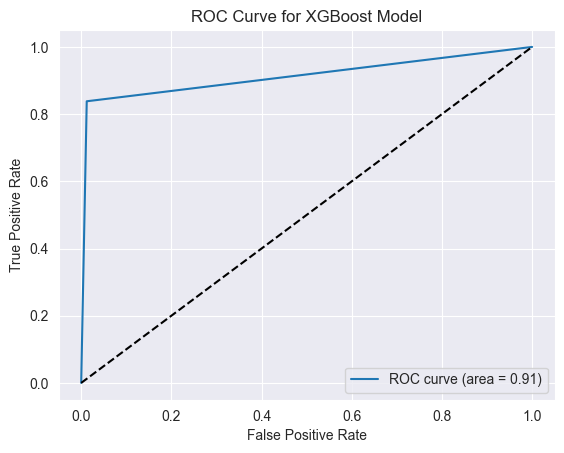

AUC: 0.9129797811475866


In [29]:
# Compute ROC curve and AUC
y_pred_tuned_xgb = xgb_tuning.predict(X_test)

roc_auc_xgb = roc_auc_score(y_test, y_pred_tuned_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_tuned_xgb)

# Plot ROC curve
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc_xgb)

##### Learning Curve

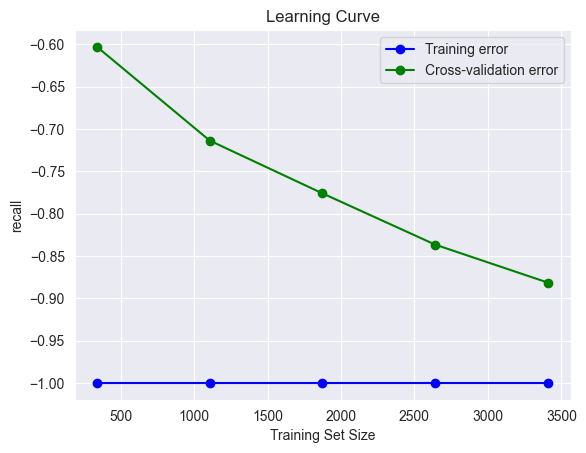

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(xgb_tuning, X_train, y_train, cv=kf, scoring='f1', n_jobs=-1)
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training error")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-validation error")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel('recall')
plt.legend()
plt.show()

In [31]:
check_overfitting(xgb_tuning)

,Metric,Train_CV,Test,Difference (%)
0,Accucary,0.961,0.964,-0.249
1,Recall,0.831,0.838,-0.861
2,Precision,0.929,0.929,-0.017
3,F1-Score,0.877,0.881,-0.507



Model does not show signs of significant overfitting based on the 10% threshold.


### Feature Importances

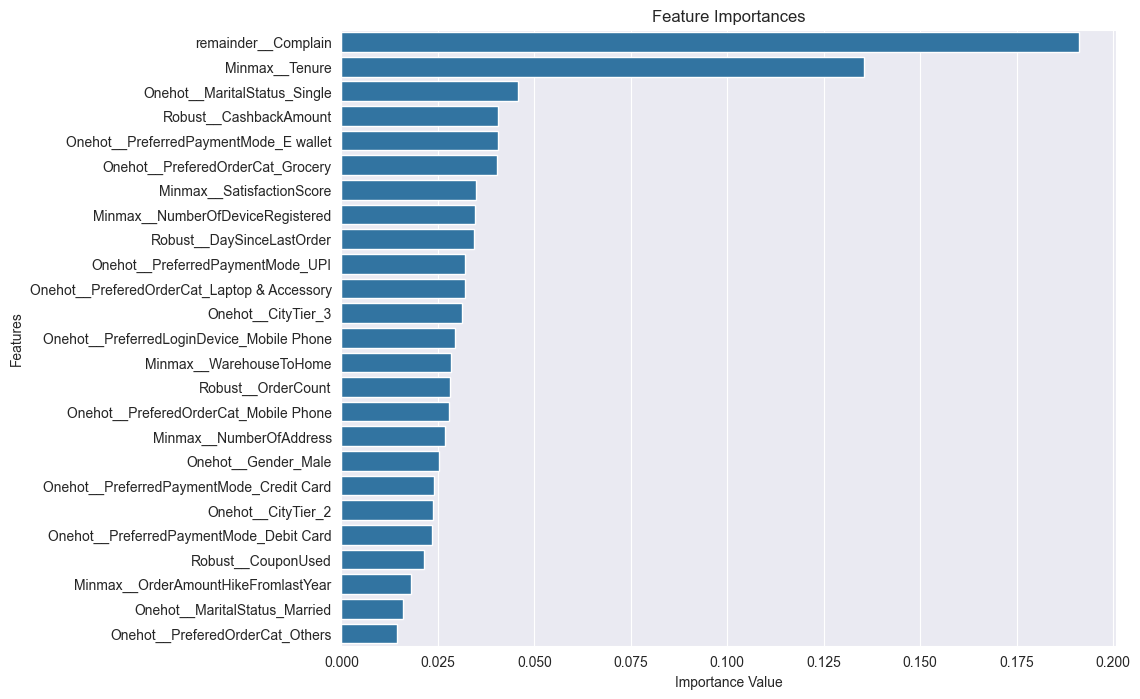

In [32]:
feature_imp = pd.DataFrame(
    xgb_tuning['model'].feature_importances_,  
    index=xgb_tuning['preprocess'].get_feature_names_out(), 
    columns=['Value']  
).sort_values(by='Value', ascending=False) 

# Plotting
plt.figure(figsize=(10, 8))  
sns.barplot(data=feature_imp, x='Value', y=feature_imp.index) 
plt.title('Feature Importances')  
plt.xlabel('Importance Value')  
plt.ylabel('Features')  
plt.show()  

In [51]:
feature_imp.head().round(2) 

,Value
remainder__Complain,0.19
Minmax__Tenure,0.14
Onehot__MaritalStatus_Single,0.05
Robust__CashbackAmount,0.04
Onehot__PreferredPaymentMode_E wallet,0.04


**Insight:**  

The feature importance provided by XGBoost to represent wich features has high impact on model:  
- **remainder__Complain (0.19)**  
  This feature is the most important in the model, suggesting that complaints are a strong indicator of the target variable wich affect customerce wether churn or not. Complain features indicate that transaction with complain tend to churn.
- **Minmax__Tenure (0.14)**  
  The tenure of customers likely influences behavior – longer tenure may correlate with loyalty or satisfaction and customers tend to stay/retained.  
- **Onehot__MaritalStatus_Single (0.05)**  
  Marital status seems to significantly affect customer behavior in the context being analyzed, single status can affect customer spending behavior correlated to their income or financial profile.
- **Robust__CashbackAmount (0.04)**  
  The amount of cashback received indicates potential attractiveness of the marketing strategies used, transaction with cahsback amount can increase customer spending and low customer acquisition cost.
- **Onehot__PreferredPaymentMode_E wallet (0.04)**  
  Preference for e-wallet suggests a trend towards digital payment solutions among customers. E-wallet offering simplicity and time cost reduction for customer during transaction process.


**SHAP**

In [34]:
import shap

columns = X.columns
prep = xgb_tuning['preprocess']
prep.fit(X_train)

feature_names = list(prep.get_feature_names_out())
X_train_transformed = pd.DataFrame(prep.transform(X_train), columns=feature_names)
X_test_transformed = pd.DataFrame(prep.transform(X_test), columns=feature_names)

best_model = xgb_tuning['model']

 99%|===================| 3747/3788 [01:15<00:00]        

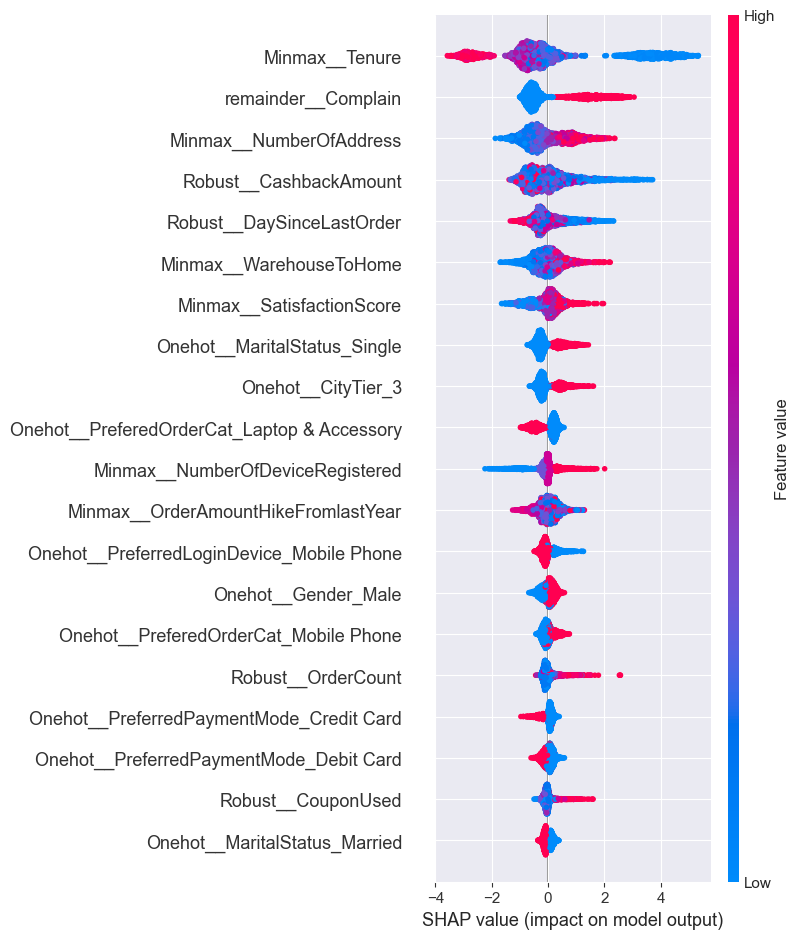

In [35]:
# # define explainer
explainer = shap.TreeExplainer(
    best_model,
    data = X_train_transformed,
)

# hitung shap value untuk tiap baris di data train
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed)


**Insight:**  

**Shap Values:**  

  *Positive SHAP Values: Indicate a higher likelihood of churn.  

  *Negative SHAP Values: Suggest a lower likelihood of churn.  

**Interpreting Features:**  
  * Minmax___Tenure: Longer tenure appears to correlate with lower churn likelihood (negative SHAP value).  

  * Remainder___Complain: Higher complaints are associated with increased churn likelihood (positive SHAP value).  

  * Minmax___NumberOfAddress: The number of addresses tends to have a neutral to slightly negative impact on churn.  

  * Robust___CashbackAmount: Higher cashback amounts are correlated with lower churn risk, suggesting that financial incentives help retain customers.  
  
  * Robust___DaySinceLastOrder: More days since the last order can indicate higher risk of churn (positive SHAP value).


In [36]:
shap.initjs()

def shap_plot(j, model, S):

    # define explainer
    explainerModel = shap.TreeExplainer(model)

    # shap value untuk baris tertentu
    shap_values_Model = explainerModel.shap_values(S)

    # force_plot
    p = shap.plots.force(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])

    return(p)

In [37]:
display(X_test.iloc[[50]], y_test.iloc[[50]])

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
803,3,Computer,1,15,Credit Card,Female,3,Laptop & Accessory,3,Single,8,1,18,1,1,7,146.95


803    0
Name: Churn, dtype: int64

In [38]:
shap_plot(50, best_model, X_test_transformed)

### Save model

In [39]:
import pickle

# Training the Best Model (before saving)
xgb_tuning.fit(X_train,y_train)

# Saving Model
pickle.dump(xgb_tuning, open('Ecommerce-customers-churn-clasification-Model.pkl','wb'))

In [40]:
try:
    with open('Ecommerce-customers-churn-clasification-Model.pkl','rb') as model_file:
        load_model = pickle.load(model_file)
except FileNotFoundError:
    print("Model file not found.")
except pickle.UnpicklingError:
    print("Error unpickling the model.")

In [41]:
dataset = pd.read_excel('dataset/E_Commerce_Dataset _Changed.xlsx', 'E Comm')
dataset = dataset.drop(columns=['CustomerID','HourSpendOnApp'])
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5366 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   NumberOfDeviceRegistered     5630 non-null   int64  
 8   PreferedOrderCat             5630 non-null   object 
 9   SatisfactionScore            5630 non-null   int64  
 10  MaritalStatus                5630 non-null   object 
 11  NumberOfAddress              5630 non-null   int64  
 12  Complain                     5630 non-null   int64  
 13  OrderAmountHikeFro

In [42]:
dataset_test = dataset.drop(columns='Churn')
label_origin = dataset['Churn']

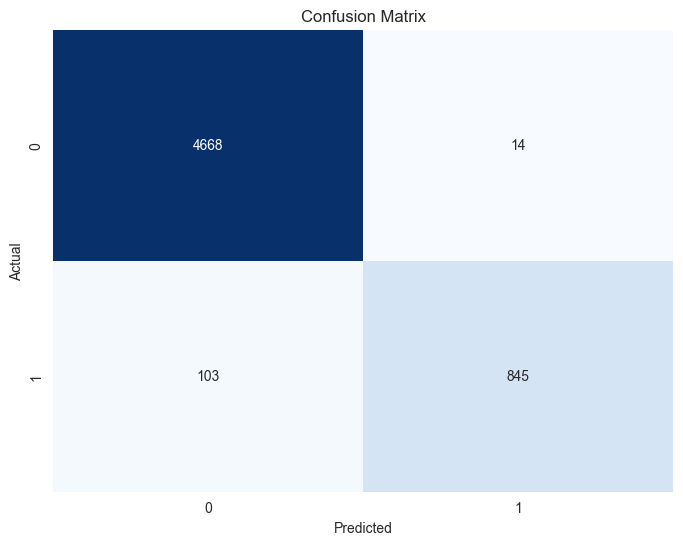

In [43]:
predicted_data = load_model.predict(dataset_test)
cm = confusion_matrix(label_origin, predicted_data)

# Step 5: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
new_dataset = dataset
new_dataset['Churn Prediction'] = predicted_data
new_dataset.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Churn Prediction
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93,1
1,1,NaN,Mobile Phone,1,8.0,UPI,Male,4,Mobile Phone,3,Single,7,1,15.0,0.0,1.0,0.0,120.90,1
2,1,NaN,Mobile Phone,1,30.0,Debit Card,Male,4,Mobile Phone,3,Single,6,1,14.0,0.0,1.0,3.0,120.28,1
3,1,0.0,Mobile Phone,3,15.0,Debit Card,Male,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07,1
4,1,0.0,Mobile Phone,1,12.0,Credit Card,Male,3,Mobile Phone,5,Single,3,0,11.0,1.0,1.0,3.0,129.60,1


In [45]:
new_dataset.to_excel('Prediction result.xlsx', index=False)

In [47]:
display(dataset['Churn'].value_counts(), dataset['CashbackAmount'].describe(),dataset['CashbackAmount'].agg(sum))

Churn
0    4682
1     948
Name: count, dtype: int64

count    5630.000000
mean      177.223030
std        49.207036
min         0.000000
25%       145.770000
50%       163.280000
75%       196.392500
max       324.990000
Name: CashbackAmount, dtype: float64

997765.6599999999

---
# **Model Explanation**
---


This model aims to provide an overview and prediction about customerce churn. The model use **f1** as evaluation metric to overcome imbalanced dataset, and provide a balance between recall and precision metric. 

### **Model Assumption**

In this model, we have main assumption as our foundation to build and tune our model: 

  1. According to [Harvard Business Review](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers), acquiring a new customer can cost **5** to **25** times more than keeping an existing customer.  
  
  2. And based on article from [Invesp](https://www.invespcro.com/blog/customer-acquisition-retention/), Positive customer experiences lead to **140%** more spending.

 Based on these assumption, we tried to interpret on actual business operation with our dataset by providing calculation based on relevant feature `CashbackAmount` as example of customer retention strategy:
  * **Data label distribution**:  
  0/Stay = 4682  
  1/Churn = 948  
  Total = 5630  

  * `CashbackAmount` **details**: 
    - Sum = $997.766  
    - Average = $177  

  * **Retention cost**  
  Retention Cost Formula = Total Costs Attributed to Retention Programs / Active Customers during the period.   **997.766 / 4682 = $213**  

  * **Acquisition cost**  
  Acquisition Cost Formula = **5 x 213 = $1065**  
  
  * **Potential repurchased**  
  For calculate potential purchased, we assume each transaction cashback amount is 5% from total transaction, based on average of `CashbackAmount` is **$177** we can conclude that total transaction is **$3560**. Based on second assumption, potential repurchased can calculated as **3560 x 1.4 = $4984**.

**Estimator summary:**  
 1. Retention cost = **$213**
 2. Acquisition cost = **$1065**
 3. Potential repurchased = **$4984**
  



#### ***Financial Impact w/o Model***

**Churn** = 944  

**Stay** = 4682  
 
**Potential repurchased** = 5630 x 4984 = $28.059.920,00  

**Potential lost repurchased** = 944 x 4984 =   -($4.724.832,00)  

**Retension cost** = 4682 x 213 =  $898.950,49  

**Cust acquisition** = 944 x 1065 =  $1.011.516,00  

**Actual lost repurchase** = 948 x 4984 =  $4.724.832,00  

**Actual repurchase** = 4682 x 4984 =  $23.335.088,00  

**Revenue** = actual repurchase - (retension cost + cust acquisition + actual lost repurchase)  

  **Revenue** = $23.335.088,00 - ($898.950,49 + $1.011.516,00 + $4.724.832,00)  

  **Revenue** =  $16.699.789,51 













#### ***Financial Impact w Model***

**Churn** = 859  

**Stay** = 4771  
 
**Potential repurchased** = 5630 x 4984 = $28.059.920,00  

**Potential lost repurchased** = 859 x 4984 = -($4.281.256,00)  

**Retension cost** = 4771 x 213 = $916.038,61  

**Cust acquisition** = 859 x 1065 = $916.553,00    

**Actual lost repurchase** = 859 x 4984 = $4.281.256,00  

**Actual repurchase** = 4771 x 4984 = $23.778.664,00  

**Revenue** = actual repurchase - (retention cost + cust acquisition + actual lost repurchase)  

**Revenue** = $23.778.664,00 - ($916.038,61 + $916.553,00 + $4.281.256,00)  

**Revenue** = $17.664.816,39  

#### ***Benefit***
**Diff cost(saved)** =	 $77.874,88  

**Diff revenue(increased)** =	 $965.026,88  

**Diff potential lost saved** =	 $443.576,00  




---
# **Summary**
--- 

### **Conclusion**  

#### ***Modeling***

  - **Algorithm:**  
  Based on model benchmark and evaluation metric, we use f1 as our metric score for fullfill our objective analisis provide a balance between recall and precision metric and overcome imbalanced target features. Based on benchmark model, XGBoost become the best model among other models.  

  - **Evaluation metrics:**  
  Metric score before and after tuning incrase for all metric score such as Roc-auc 0.02, Accuracy 0.01, Precision 0.03, Recall 0.03, and F1 Score 0.03. It provide a good model for predict customer churn or not.  

  - **Feature importances:**  
  Based on model feature importances, there are top 5 feature importance that affect model:
    * remainder__Complain
    * Minmax__Tenure
    * Onehot__MaritalStatus_Single 
    * Robust__CashbackAmount
    * Onehot__PreferredPaymentMode_E wallet  

    Based on SHAP:
      * Minmax___Tenure
      * Remainder___Complain
      * Minmax___NumberOfAddress
      * Robust___CashbackAmount
      * Robust___DaySinceLastOrder

  - **Business implication:**  
  The model based on business assumption and result predict original data has proven that give benefit for several business need, such as:

    * Diff cost(saved) =	 $77.874,88  

    * Diff revenue(increased) =	 $965.026,88  

    * Diff potential lost saved =	 $443.576,00  

#### ***Analysis***

  - **Early-Life Churn:**  
      - The majority of customers stop using the service within the first two months.  
      - Despite high initial usage, over 50% of customers experience churn during the early period.

  - **Impact of Complaints:**  
     - Customers who file complaints have a significantly higher churn rate (approximately 31.3%) compared to those who do not.

  - **Satisfaction Paradox:**  
     - High satisfaction scores do not always guarantee loyalty.  
     - Customers with high expectations may quickly switch if the service does not meet their expectations.

  - **Last Transaction:**  
     - Customers who churn continue to make transactions in the early days (0-7 days).  
     - The variable *DaySinceLastOrder* is not a primary factor causing churn.

  - **Purchasing Behavior and Cashback:**  
     - Customers purchasing mobile products exhibit the highest churn and receive lower cashback.  
     - Non-churn customers tend to receive higher cashback values.

  - **Payment Methods:**  
     - The use of COD (Cash On Delivery) is associated with higher churn, possibly due to challenges in the return and refund process.

  - **Promotional Effectiveness:**  
     - Coupon usage does not show a significant difference between churn and non-churn customers.  
     - However, the analysis of cashback indicates that higher cashback received is associated with lower churn rates.

  - **Usage Platform:**  
     - Mobile app users have a lower churn rate (15.4%) compared to website users (19.6%).

  - **Demographics:**  
     - Male customers are slightly more prone to churn than female customers.  
     - Single customers have a very high churn rate (≈26.7%) and tend to have a shorter tenure.




### **Limitation**

* Changing Patterns: Customer behavior and preferences can change over time due to market trends, economic factors, or changes in the competitive landscape. A model trained on historical data may not adapt well to new patterns. 
* Data limitations: The model depends on the quality and relevance of the dataset provided. For churn  cases, perhaps new data collection and features will provide better data accuracy and business relevance.


### **Recommendation**

**Optimizing Service and Customer Experience:**  
- Improve customer support by providing comprehensive FAQs, chatbots for quick responses, and clear escalation paths.  
- Ensure product availability and enhance payment and delivery processes to reduce early-life churn.

**Promotional and Cashback Strategy:**  
- Increase cashback, especially for the mobile product category, as higher cashback has been shown to contribute to customer retention.  
- Conduct A/B testing to determine the optimal promotional strategy by combining cashback promotions with other incentives.

**Enhancing Digital Experience:**  
- Improve the website's user experience through A/B testing and redesigning underperforming features.  
- Encourage mobile app usage by offering incentives or exclusive loyalty programs.

**Segmentation and Marketing Personalization:**  
- Target male and single customers separately, as they exhibit higher churn rates.  
- Develop exclusive offers, satisfaction surveys, and product recommendations tailored to the preferences of each segment, particularly for single customers who tend to be more experimental.

**Evaluating Payment Methods:**  
- Reassess the COD method by improving cooperation with relevant parties, establishing clearer return policies, and implementing an effective mediation system to handle complaints.

**Comprehensive Loyalty Measurement:**  
- Use a combination of metrics, such as merging satisfaction scores with Customer Effort Score (CES), to gain a deeper understanding of customer loyalty and satisfaction.